In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1= pd.read_csv("../input/sunpharma-data-redefined/Previous30DayClose.csv", index_col= "Date", parse_dates= True)
df1

,Open,High,Low,Close,Adj Close,Volume,Growth% of Close from previous 30 days
Date,,,,,,,
2009-12-01,145.354996,155.500000,145.354996,153.990005,144.129593,4338810.0,-7.006953
2009-12-02,156.399994,160.000000,148.660004,149.720001,140.133011,4689480.0,-3.519906
2009-12-03,150.014999,152.100006,148.750000,149.475006,139.903687,2534030.0,-4.933935
2009-12-04,148.500000,150.880005,145.110001,148.270004,138.775833,1216690.0,-2.461731
2009-12-07,148.509995,149.789993,144.110001,145.190002,135.893051,1559620.0,1.456706
...,...,...,...,...,...,...,...
2021-02-08,640.900024,644.849976,632.549988,634.650024,629.150024,6479801.0,-7.374151
2021-02-09,631.900024,639.250000,621.000000,623.599976,623.599976,5794015.0,-6.141756
2021-02-10,623.049988,631.549988,614.099976,627.099976,627.099976,6902162.0,-8.188483


<AxesSubplot:title={'center':'Sunpharma Closing price'}, xlabel='Date'>

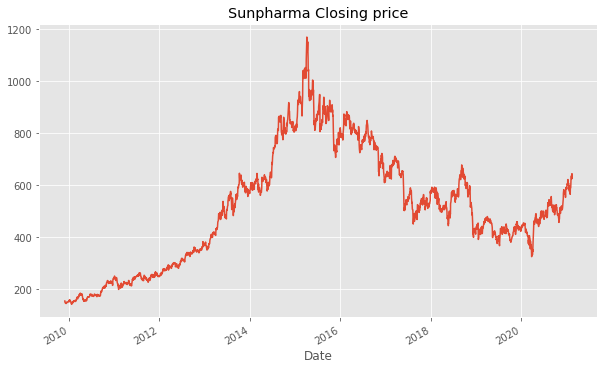

In [3]:
plt.style.use("ggplot")

df1["Close"].plot(label="Close", title="Sunpharma Closing price", figsize=(10,6))

## Data Preprocessing...  

In [4]:
# Features and Target segmentation
data = df1.iloc[:, 6:7].values # .values to convert it to numpy array

In [5]:
type(data)

numpy.ndarray

In [6]:
# Data Normalization

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler(feature_range= (0, 1))
ss = StandardScaler()

data_scaled = mm.fit_transform(data)
data_scaled

array([[0.33311583],
       [0.37967157],
       [0.3607928 ],
       ...,
       [0.31734117],
       [0.30957336],
       [0.36397152]])

In [7]:
# Keeping last 30 values(about a month) for testing
train_data = data_scaled[:2726, :]
test_data= data_scaled[2726:, :]

print(train_data.shape)
print(test_data.shape)

(2726, 1)
(31, 1)


In [8]:
# Creating a datastructure with 60 time stamps and 1 output(only on training set)

x_train= []
y_train= []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, :])
    y_train.append(train_data[i, 0])
    
# Converting them to numpy arrays
x_train, y_train= np.array(x_train), np.array(y_train)

In [9]:
x_train. shape, y_train.shape

((2636, 90, 1), (2636,))

In [10]:
y_train= y_train.reshape(y_train.shape[0], 1)
y_train.shape

(2636, 1)

In [11]:
# Importing dependencies
import torch 
import torch.nn as nn
from torch.autograd import Variable 

In [12]:
X_train_tensors = Variable(torch.Tensor(x_train)).cuda()
# X_test_tensors = Variable(torch.Tensor(X_test)).cuda()

y_train_tensors = Variable(torch.Tensor(y_train)).cuda()
# y_test_tensors = Variable(torch.Tensor(y_test)) .cuda()

In [13]:
# Reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

# X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))


# Printing shapes 
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
# print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([2636, 1, 90]) torch.Size([2636, 1])


## Network Defination....

In [14]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length = seq_length # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() # internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        output = output.view(-1, self.hidden_size) # reshaping the output for fc layer
        out = self.relu(output)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

## Important parameters.... 

In [19]:
num_epochs = 75000 
learning_rate = 0.003 

input_size = 90 # number of features
hidden_size = 8 # number of features in hidden state
num_layers = 3 # number of stacked lstm layers

num_classes = 1 # number of output classes(coz regression)

In [20]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).cuda() #our lstm class

In [21]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

## Training Loop.... 

In [22]:
loss_min = np.Inf

for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function
 
    # save model if loss has decreased
    if loss.item() <= loss_min:
        print('Loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        loss_min,
        loss.item()))
        checkpoint = {'model': lstm1,
              'state_dict': lstm1.state_dict(),
              'optimizer' : optimizer.state_dict(),
              'train_loss': loss.item()}

        torch.save(checkpoint, 'checkpoint.pth')
        loss_min = loss.item()

    optimizer.step() #improve from loss, i.e backprop
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Loss decreased (inf --> 0.236942).  Saving model ...
Epoch: 0, loss: 0.23694
Loss decreased (0.236942 --> 0.197605).  Saving model ...
Loss decreased (0.197605 --> 0.162571).  Saving model ...
Loss decreased (0.162571 --> 0.131743).  Saving model ...
Loss decreased (0.131743 --> 0.104989).  Saving model ...
Loss decreased (0.104989 --> 0.082191).  Saving model ...
Loss decreased (0.082191 --> 0.063205).  Saving model ...
Loss decreased (0.063205 --> 0.047835).  Saving model ...
Loss decreased (0.047835 --> 0.035862).  Saving model ...
Loss decreased (0.035862 --> 0.027075).  Saving model ...
Loss decreased (0.027075 --> 0.021207).  Saving model ...
Loss decreased (0.021207 --> 0.017944).  Saving model ...
Loss decreased (0.017944 --> 0.016868).  Saving model ...
Loss decreased (0.016868 --> 0.016867).  Saving model ...
Loss decreased (0.016867 --> 0.016867).  Saving model ...
Epoch: 100, loss: 0.01687
Loss decreased (0.016867 --> 0.016867).  Saving model ...
Loss decreased (0.016867 --

Loss decreased (0.016843 --> 0.016842).  Saving model ...
Loss decreased (0.016842 --> 0.016840).  Saving model ...
Loss decreased (0.016840 --> 0.016838).  Saving model ...
Loss decreased (0.016838 --> 0.016836).  Saving model ...
Loss decreased (0.016836 --> 0.016834).  Saving model ...
Loss decreased (0.016834 --> 0.016832).  Saving model ...
Loss decreased (0.016832 --> 0.016829).  Saving model ...
Loss decreased (0.016829 --> 0.016826).  Saving model ...
Loss decreased (0.016826 --> 0.016823).  Saving model ...
Loss decreased (0.016823 --> 0.016819).  Saving model ...
Loss decreased (0.016819 --> 0.016815).  Saving model ...
Loss decreased (0.016815 --> 0.016811).  Saving model ...
Loss decreased (0.016811 --> 0.016806).  Saving model ...
Loss decreased (0.016806 --> 0.016801).  Saving model ...
Loss decreased (0.016801 --> 0.016795).  Saving model ...
Loss decreased (0.016795 --> 0.016789).  Saving model ...
Loss decreased (0.016789 --> 0.016782).  Saving model ...
Loss decreased

Loss decreased (0.001938 --> 0.001901).  Saving model ...
Loss decreased (0.001901 --> 0.001856).  Saving model ...
Loss decreased (0.001856 --> 0.001820).  Saving model ...
Loss decreased (0.001820 --> 0.001814).  Saving model ...
Loss decreased (0.001814 --> 0.001787).  Saving model ...
Loss decreased (0.001787 --> 0.001783).  Saving model ...
Loss decreased (0.001783 --> 0.001758).  Saving model ...
Loss decreased (0.001758 --> 0.001753).  Saving model ...
Loss decreased (0.001753 --> 0.001737).  Saving model ...
Loss decreased (0.001737 --> 0.001721).  Saving model ...
Loss decreased (0.001721 --> 0.001715).  Saving model ...
Loss decreased (0.001715 --> 0.001710).  Saving model ...
Loss decreased (0.001710 --> 0.001698).  Saving model ...
Loss decreased (0.001698 --> 0.001686).  Saving model ...
Loss decreased (0.001686 --> 0.001677).  Saving model ...
Loss decreased (0.001677 --> 0.001670).  Saving model ...
Loss decreased (0.001670 --> 0.001666).  Saving model ...
Loss decreased

Loss decreased (0.001097 --> 0.001096).  Saving model ...
Loss decreased (0.001096 --> 0.001091).  Saving model ...
Loss decreased (0.001091 --> 0.001089).  Saving model ...
Loss decreased (0.001089 --> 0.001086).  Saving model ...
Loss decreased (0.001086 --> 0.001082).  Saving model ...
Loss decreased (0.001082 --> 0.001078).  Saving model ...
Loss decreased (0.001078 --> 0.001076).  Saving model ...
Loss decreased (0.001076 --> 0.001074).  Saving model ...
Loss decreased (0.001074 --> 0.001073).  Saving model ...
Loss decreased (0.001073 --> 0.001073).  Saving model ...
Loss decreased (0.001073 --> 0.001070).  Saving model ...
Loss decreased (0.001070 --> 0.001069).  Saving model ...
Loss decreased (0.001069 --> 0.001067).  Saving model ...
Loss decreased (0.001067 --> 0.001066).  Saving model ...
Loss decreased (0.001066 --> 0.001064).  Saving model ...
Loss decreased (0.001064 --> 0.001064).  Saving model ...
Loss decreased (0.001064 --> 0.001063).  Saving model ...
Loss decreased

Loss decreased (0.000955 --> 0.000955).  Saving model ...
Loss decreased (0.000955 --> 0.000954).  Saving model ...
Loss decreased (0.000954 --> 0.000954).  Saving model ...
Loss decreased (0.000954 --> 0.000954).  Saving model ...
Loss decreased (0.000954 --> 0.000954).  Saving model ...
Loss decreased (0.000954 --> 0.000954).  Saving model ...
Loss decreased (0.000954 --> 0.000953).  Saving model ...
Loss decreased (0.000953 --> 0.000953).  Saving model ...
Loss decreased (0.000953 --> 0.000953).  Saving model ...
Loss decreased (0.000953 --> 0.000953).  Saving model ...
Loss decreased (0.000953 --> 0.000953).  Saving model ...
Loss decreased (0.000953 --> 0.000952).  Saving model ...
Loss decreased (0.000952 --> 0.000952).  Saving model ...
Loss decreased (0.000952 --> 0.000952).  Saving model ...
Loss decreased (0.000952 --> 0.000952).  Saving model ...
Loss decreased (0.000952 --> 0.000951).  Saving model ...
Loss decreased (0.000951 --> 0.000951).  Saving model ...
Loss decreased

Loss decreased (0.000878 --> 0.000876).  Saving model ...
Loss decreased (0.000876 --> 0.000875).  Saving model ...
Loss decreased (0.000875 --> 0.000873).  Saving model ...
Loss decreased (0.000873 --> 0.000873).  Saving model ...
Loss decreased (0.000873 --> 0.000871).  Saving model ...
Loss decreased (0.000871 --> 0.000870).  Saving model ...
Loss decreased (0.000870 --> 0.000870).  Saving model ...
Loss decreased (0.000870 --> 0.000869).  Saving model ...
Epoch: 1900, loss: 0.00133
Loss decreased (0.000869 --> 0.000868).  Saving model ...
Loss decreased (0.000868 --> 0.000867).  Saving model ...
Loss decreased (0.000867 --> 0.000866).  Saving model ...
Loss decreased (0.000866 --> 0.000866).  Saving model ...
Loss decreased (0.000866 --> 0.000865).  Saving model ...
Loss decreased (0.000865 --> 0.000864).  Saving model ...
Loss decreased (0.000864 --> 0.000864).  Saving model ...
Loss decreased (0.000864 --> 0.000864).  Saving model ...
Loss decreased (0.000864 --> 0.000863).  Savi

Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000823).  Saving model ...
Loss decreased (0.000823 --> 0.000822).  Saving model ...
Loss decreased (0.000822 --> 0.000822).  Saving model ...
Epoch: 2600, loss: 0.00082
Loss decreased (0.000822 --> 0.000822).  Saving model ...
Loss decreased (0.000822 --> 0.000821).  Saving model ...
Loss decreased (0.000821 --> 0.000820).  Saving model ...
Loss decreased (0.000820 --> 0.000820).  Saving model ...
Loss decreased (0.000820 --> 0.000819).  Savi

Loss decreased (0.000798 --> 0.000798).  Saving model ...
Loss decreased (0.000798 --> 0.000797).  Saving model ...
Loss decreased (0.000797 --> 0.000797).  Saving model ...
Loss decreased (0.000797 --> 0.000797).  Saving model ...
Epoch: 3300, loss: 0.00080
Loss decreased (0.000797 --> 0.000796).  Saving model ...
Loss decreased (0.000796 --> 0.000796).  Saving model ...
Loss decreased (0.000796 --> 0.000796).  Saving model ...
Loss decreased (0.000796 --> 0.000796).  Saving model ...
Loss decreased (0.000796 --> 0.000795).  Saving model ...
Loss decreased (0.000795 --> 0.000795).  Saving model ...
Loss decreased (0.000795 --> 0.000795).  Saving model ...
Loss decreased (0.000795 --> 0.000795).  Saving model ...
Loss decreased (0.000795 --> 0.000795).  Saving model ...
Loss decreased (0.000795 --> 0.000794).  Saving model ...
Loss decreased (0.000794 --> 0.000794).  Saving model ...
Loss decreased (0.000794 --> 0.000793).  Saving model ...
Epoch: 3400, loss: 0.00080
Loss decreased (0.

Epoch: 4500, loss: 0.00082
Loss decreased (0.000767 --> 0.000767).  Saving model ...
Loss decreased (0.000767 --> 0.000766).  Saving model ...
Loss decreased (0.000766 --> 0.000766).  Saving model ...
Loss decreased (0.000766 --> 0.000766).  Saving model ...
Loss decreased (0.000766 --> 0.000766).  Saving model ...
Epoch: 4600, loss: 0.00107
Loss decreased (0.000766 --> 0.000766).  Saving model ...
Loss decreased (0.000766 --> 0.000765).  Saving model ...
Loss decreased (0.000765 --> 0.000765).  Saving model ...
Loss decreased (0.000765 --> 0.000765).  Saving model ...
Loss decreased (0.000765 --> 0.000764).  Saving model ...
Epoch: 4700, loss: 0.00076
Loss decreased (0.000764 --> 0.000764).  Saving model ...
Loss decreased (0.000764 --> 0.000764).  Saving model ...
Loss decreased (0.000764 --> 0.000763).  Saving model ...
Loss decreased (0.000763 --> 0.000763).  Saving model ...
Loss decreased (0.000763 --> 0.000763).  Saving model ...
Loss decreased (0.000763 --> 0.000763).  Saving m

Epoch: 6600, loss: 0.00083
Loss decreased (0.000736 --> 0.000736).  Saving model ...
Loss decreased (0.000736 --> 0.000736).  Saving model ...
Loss decreased (0.000736 --> 0.000735).  Saving model ...
Loss decreased (0.000735 --> 0.000735).  Saving model ...
Epoch: 6700, loss: 0.00075
Loss decreased (0.000735 --> 0.000735).  Saving model ...
Loss decreased (0.000735 --> 0.000735).  Saving model ...
Loss decreased (0.000735 --> 0.000734).  Saving model ...
Loss decreased (0.000734 --> 0.000734).  Saving model ...
Loss decreased (0.000734 --> 0.000734).  Saving model ...
Epoch: 6800, loss: 0.00074
Loss decreased (0.000734 --> 0.000734).  Saving model ...
Loss decreased (0.000734 --> 0.000733).  Saving model ...
Loss decreased (0.000733 --> 0.000733).  Saving model ...
Epoch: 6900, loss: 0.00078
Loss decreased (0.000733 --> 0.000733).  Saving model ...
Loss decreased (0.000733 --> 0.000733).  Saving model ...
Loss decreased (0.000733 --> 0.000732).  Saving model ...
Loss decreased (0.0007

Loss decreased (0.000715 --> 0.000715).  Saving model ...
Epoch: 8500, loss: 0.00075
Loss decreased (0.000715 --> 0.000714).  Saving model ...
Loss decreased (0.000714 --> 0.000714).  Saving model ...
Loss decreased (0.000714 --> 0.000714).  Saving model ...
Loss decreased (0.000714 --> 0.000714).  Saving model ...
Epoch: 8600, loss: 0.00085
Loss decreased (0.000714 --> 0.000714).  Saving model ...
Loss decreased (0.000714 --> 0.000714).  Saving model ...
Loss decreased (0.000714 --> 0.000713).  Saving model ...
Loss decreased (0.000713 --> 0.000713).  Saving model ...
Loss decreased (0.000713 --> 0.000713).  Saving model ...
Epoch: 8700, loss: 0.00072
Loss decreased (0.000713 --> 0.000712).  Saving model ...
Loss decreased (0.000712 --> 0.000712).  Saving model ...
Loss decreased (0.000712 --> 0.000712).  Saving model ...
Loss decreased (0.000712 --> 0.000712).  Saving model ...
Loss decreased (0.000712 --> 0.000711).  Saving model ...
Epoch: 8800, loss: 0.00072
Loss decreased (0.0007

Loss decreased (0.000691 --> 0.000690).  Saving model ...
Loss decreased (0.000690 --> 0.000690).  Saving model ...
Epoch: 11200, loss: 0.00079
Loss decreased (0.000690 --> 0.000690).  Saving model ...
Loss decreased (0.000690 --> 0.000690).  Saving model ...
Loss decreased (0.000690 --> 0.000689).  Saving model ...
Loss decreased (0.000689 --> 0.000689).  Saving model ...
Loss decreased (0.000689 --> 0.000689).  Saving model ...
Loss decreased (0.000689 --> 0.000689).  Saving model ...
Loss decreased (0.000689 --> 0.000689).  Saving model ...
Loss decreased (0.000689 --> 0.000689).  Saving model ...
Epoch: 11300, loss: 0.00069
Loss decreased (0.000689 --> 0.000688).  Saving model ...
Loss decreased (0.000688 --> 0.000688).  Saving model ...
Epoch: 11400, loss: 0.00069
Loss decreased (0.000688 --> 0.000688).  Saving model ...
Loss decreased (0.000688 --> 0.000688).  Saving model ...
Epoch: 11500, loss: 0.00072
Loss decreased (0.000688 --> 0.000687).  Saving model ...
Loss decreased (0.

Epoch: 14400, loss: 0.00074
Loss decreased (0.000664 --> 0.000664).  Saving model ...
Loss decreased (0.000664 --> 0.000664).  Saving model ...
Loss decreased (0.000664 --> 0.000663).  Saving model ...
Loss decreased (0.000663 --> 0.000663).  Saving model ...
Loss decreased (0.000663 --> 0.000663).  Saving model ...
Loss decreased (0.000663 --> 0.000663).  Saving model ...
Loss decreased (0.000663 --> 0.000663).  Saving model ...
Epoch: 14500, loss: 0.00066
Loss decreased (0.000663 --> 0.000663).  Saving model ...
Loss decreased (0.000663 --> 0.000662).  Saving model ...
Loss decreased (0.000662 --> 0.000662).  Saving model ...
Epoch: 14600, loss: 0.00067
Loss decreased (0.000662 --> 0.000662).  Saving model ...
Loss decreased (0.000662 --> 0.000662).  Saving model ...
Loss decreased (0.000662 --> 0.000661).  Saving model ...
Loss decreased (0.000661 --> 0.000661).  Saving model ...
Epoch: 14700, loss: 0.00070
Loss decreased (0.000661 --> 0.000661).  Saving model ...
Loss decreased (0.

Loss decreased (0.000639 --> 0.000639).  Saving model ...
Loss decreased (0.000639 --> 0.000639).  Saving model ...
Loss decreased (0.000639 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Epoch: 18100, loss: 0.00065
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000638).  Saving model ...
Loss decreased (0.000638 --> 0.000637).  Saving model ...
Loss decreased (0.000637 --> 0.000637).  Saving model ...
Loss decreased (0.000637 --> 0.000637).  Saving model ...
Loss decreased (0.000637 --> 0.000637).  Saving model ...
Epoch: 18200, loss: 0.00064
Loss decreased (

Loss decreased (0.000618 --> 0.000618).  Saving model ...
Loss decreased (0.000618 --> 0.000618).  Saving model ...
Loss decreased (0.000618 --> 0.000618).  Saving model ...
Epoch: 21200, loss: 0.00063
Loss decreased (0.000618 --> 0.000617).  Saving model ...
Epoch: 21300, loss: 0.00064
Loss decreased (0.000617 --> 0.000617).  Saving model ...
Loss decreased (0.000617 --> 0.000617).  Saving model ...
Loss decreased (0.000617 --> 0.000616).  Saving model ...
Epoch: 21400, loss: 0.00063
Loss decreased (0.000616 --> 0.000616).  Saving model ...
Loss decreased (0.000616 --> 0.000616).  Saving model ...
Loss decreased (0.000616 --> 0.000616).  Saving model ...
Epoch: 21500, loss: 0.00063
Loss decreased (0.000616 --> 0.000616).  Saving model ...
Loss decreased (0.000616 --> 0.000615).  Saving model ...
Loss decreased (0.000615 --> 0.000615).  Saving model ...
Loss decreased (0.000615 --> 0.000615).  Saving model ...
Epoch: 21600, loss: 0.00064
Loss decreased (0.000615 --> 0.000615).  Saving 

Loss decreased (0.000595 --> 0.000595).  Saving model ...
Loss decreased (0.000595 --> 0.000595).  Saving model ...
Loss decreased (0.000595 --> 0.000594).  Saving model ...
Epoch: 24900, loss: 0.00065
Loss decreased (0.000594 --> 0.000594).  Saving model ...
Loss decreased (0.000594 --> 0.000594).  Saving model ...
Loss decreased (0.000594 --> 0.000594).  Saving model ...
Epoch: 25000, loss: 0.00063
Loss decreased (0.000594 --> 0.000594).  Saving model ...
Loss decreased (0.000594 --> 0.000594).  Saving model ...
Loss decreased (0.000594 --> 0.000593).  Saving model ...
Epoch: 25100, loss: 0.00059
Loss decreased (0.000593 --> 0.000593).  Saving model ...
Loss decreased (0.000593 --> 0.000593).  Saving model ...
Loss decreased (0.000593 --> 0.000592).  Saving model ...
Epoch: 25200, loss: 0.00060
Loss decreased (0.000592 --> 0.000592).  Saving model ...
Epoch: 25300, loss: 0.00062
Loss decreased (0.000592 --> 0.000592).  Saving model ...
Loss decreased (0.000592 --> 0.000592).  Saving 

Loss decreased (0.000571 --> 0.000571).  Saving model ...
Loss decreased (0.000571 --> 0.000571).  Saving model ...
Epoch: 29100, loss: 0.00060
Loss decreased (0.000571 --> 0.000571).  Saving model ...
Loss decreased (0.000571 --> 0.000571).  Saving model ...
Loss decreased (0.000571 --> 0.000570).  Saving model ...
Epoch: 29200, loss: 0.00059
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Epoch: 29300, loss: 0.00057
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000570).  Saving model ...
Loss decreased (0.000570 --> 0.000569).  Savin

Loss decreased (0.000552 --> 0.000552).  Saving model ...
Epoch: 32700, loss: 0.00057
Loss decreased (0.000552 --> 0.000552).  Saving model ...
Loss decreased (0.000552 --> 0.000552).  Saving model ...
Loss decreased (0.000552 --> 0.000551).  Saving model ...
Epoch: 32800, loss: 0.00062
Loss decreased (0.000551 --> 0.000551).  Saving model ...
Loss decreased (0.000551 --> 0.000551).  Saving model ...
Loss decreased (0.000551 --> 0.000551).  Saving model ...
Loss decreased (0.000551 --> 0.000551).  Saving model ...
Epoch: 32900, loss: 0.00059
Loss decreased (0.000551 --> 0.000551).  Saving model ...
Epoch: 33000, loss: 0.00060
Loss decreased (0.000551 --> 0.000550).  Saving model ...
Loss decreased (0.000550 --> 0.000550).  Saving model ...
Loss decreased (0.000550 --> 0.000550).  Saving model ...
Loss decreased (0.000550 --> 0.000550).  Saving model ...
Epoch: 33100, loss: 0.00059
Loss decreased (0.000550 --> 0.000550).  Saving model ...
Loss decreased (0.000550 --> 0.000549).  Saving 

Epoch: 37000, loss: 0.00056
Loss decreased (0.000533 --> 0.000532).  Saving model ...
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Epoch: 37100, loss: 0.00055
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Epoch: 37200, loss: 0.00056
Loss decreased (0.000532 --> 0.000532).  Saving model ...
Loss decreased (0.000532 --> 0.000531).  Saving model ...
Loss decreased (0.000531 --> 0.000531).  Saving model ...
Epoch: 37300, loss: 0.00055
Epoch: 37400, loss: 0.00056
Loss decreased (0.000531 --> 0.000531).  Saving model ...
Loss decreased (0.000531 --> 0.000531).  Saving model ...
Loss decreased (0.000531 --> 0.000530).  Saving model ...
Loss decreased (0.000530 --> 0.000530).  Saving model ...
Epoch: 37500, loss: 0.00053
Loss decreased (0.00

Loss decreased (0.000513 --> 0.000513).  Saving model ...
Loss decreased (0.000513 --> 0.000512).  Saving model ...
Loss decreased (0.000512 --> 0.000512).  Saving model ...
Epoch: 42000, loss: 0.00055
Epoch: 42100, loss: 0.00051
Loss decreased (0.000512 --> 0.000512).  Saving model ...
Loss decreased (0.000512 --> 0.000512).  Saving model ...
Loss decreased (0.000512 --> 0.000512).  Saving model ...
Epoch: 42200, loss: 0.00054
Loss decreased (0.000512 --> 0.000511).  Saving model ...
Epoch: 42300, loss: 0.00052
Loss decreased (0.000511 --> 0.000511).  Saving model ...
Loss decreased (0.000511 --> 0.000511).  Saving model ...
Epoch: 42400, loss: 0.00055
Loss decreased (0.000511 --> 0.000511).  Saving model ...
Epoch: 42500, loss: 0.00053
Loss decreased (0.000511 --> 0.000511).  Saving model ...
Loss decreased (0.000511 --> 0.000511).  Saving model ...
Loss decreased (0.000511 --> 0.000510).  Saving model ...
Loss decreased (0.000510 --> 0.000510).  Saving model ...
Epoch: 42600, loss: 

Epoch: 47300, loss: 0.00049
Loss decreased (0.000494 --> 0.000494).  Saving model ...
Loss decreased (0.000494 --> 0.000494).  Saving model ...
Loss decreased (0.000494 --> 0.000493).  Saving model ...
Epoch: 47400, loss: 0.00059
Loss decreased (0.000493 --> 0.000493).  Saving model ...
Loss decreased (0.000493 --> 0.000493).  Saving model ...
Loss decreased (0.000493 --> 0.000493).  Saving model ...
Epoch: 47500, loss: 0.00064
Loss decreased (0.000493 --> 0.000493).  Saving model ...
Loss decreased (0.000493 --> 0.000493).  Saving model ...
Epoch: 47600, loss: 0.00050
Loss decreased (0.000493 --> 0.000493).  Saving model ...
Loss decreased (0.000493 --> 0.000492).  Saving model ...
Epoch: 47700, loss: 0.00050
Loss decreased (0.000492 --> 0.000492).  Saving model ...
Loss decreased (0.000492 --> 0.000492).  Saving model ...
Loss decreased (0.000492 --> 0.000492).  Saving model ...
Epoch: 47800, loss: 0.00050
Loss decreased (0.000492 --> 0.000492).  Saving model ...
Loss decreased (0.00

Loss decreased (0.000475 --> 0.000475).  Saving model ...
Loss decreased (0.000475 --> 0.000475).  Saving model ...
Loss decreased (0.000475 --> 0.000475).  Saving model ...
Loss decreased (0.000475 --> 0.000474).  Saving model ...
Epoch: 52600, loss: 0.00059
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Epoch: 52700, loss: 0.00055
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Epoch: 52800, loss: 0.00056
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Epoch: 52900, loss: 0.00050
Loss decreased (0.000474 --> 0.000474).  Saving model ...
Loss decreased (0.000474 --> 0.000473).  Saving model ...
Epoch: 53000, loss: 0.00050
Loss decreased (0.000473 --> 0.000473).  Saving model ...
Epoch: 53100, loss: 0.00052
Loss decreased (0.00

Epoch: 58600, loss: 0.00051
Loss decreased (0.000455 --> 0.000455).  Saving model ...
Loss decreased (0.000455 --> 0.000455).  Saving model ...
Epoch: 58700, loss: 0.00047
Epoch: 58800, loss: 0.00047
Loss decreased (0.000455 --> 0.000455).  Saving model ...
Loss decreased (0.000455 --> 0.000455).  Saving model ...
Loss decreased (0.000455 --> 0.000454).  Saving model ...
Loss decreased (0.000454 --> 0.000454).  Saving model ...
Epoch: 58900, loss: 0.00046
Epoch: 59000, loss: 0.00046
Epoch: 59100, loss: 0.00050
Loss decreased (0.000454 --> 0.000454).  Saving model ...
Epoch: 59200, loss: 0.00048
Loss decreased (0.000454 --> 0.000454).  Saving model ...
Loss decreased (0.000454 --> 0.000454).  Saving model ...
Epoch: 59300, loss: 0.00050
Loss decreased (0.000454 --> 0.000453).  Saving model ...
Loss decreased (0.000453 --> 0.000453).  Saving model ...
Epoch: 59400, loss: 0.00045
Loss decreased (0.000453 --> 0.000453).  Saving model ...
Loss decreased (0.000453 --> 0.000453).  Saving mode

Loss decreased (0.000436 --> 0.000436).  Saving model ...
Loss decreased (0.000436 --> 0.000436).  Saving model ...
Epoch: 65900, loss: 0.00050
Epoch: 66000, loss: 0.00046
Epoch: 66100, loss: 0.00046
Loss decreased (0.000436 --> 0.000436).  Saving model ...
Loss decreased (0.000436 --> 0.000435).  Saving model ...
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Epoch: 66200, loss: 0.00050
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Epoch: 66300, loss: 0.00044
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Epoch: 66400, loss: 0.00046
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Epoch: 66500, loss: 0.00043
Loss decreased (0.000435 --> 0.000435).  Saving model ...
Loss decreased (0.000435 --> 0.000434).  Saving model ...
Epoch: 66600, loss: 0.00048
Loss decreased (0.000434 --> 0.000434).  Saving model ...
Epoch: 66700, loss: 0.

Loss decreased (0.000418 --> 0.000418).  Saving model ...
Loss decreased (0.000418 --> 0.000418).  Saving model ...
Loss decreased (0.000418 --> 0.000418).  Saving model ...
Epoch: 74100, loss: 0.00049
Epoch: 74200, loss: 0.00044
Loss decreased (0.000418 --> 0.000418).  Saving model ...
Loss decreased (0.000418 --> 0.000417).  Saving model ...
Epoch: 74300, loss: 0.00047
Epoch: 74400, loss: 0.00045
Epoch: 74500, loss: 0.00042
Loss decreased (0.000417 --> 0.000417).  Saving model ...
Epoch: 74600, loss: 0.00042
Loss decreased (0.000417 --> 0.000417).  Saving model ...
Epoch: 74700, loss: 0.00043
Epoch: 74800, loss: 0.00047
Loss decreased (0.000417 --> 0.000417).  Saving model ...
Epoch: 74900, loss: 0.00045
Loss decreased (0.000417 --> 0.000416).  Saving model ...


## Loading model with minimum loss 

In [23]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    train_loss= checkpoint['train_loss']
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model, train_loss

In [24]:
model_best, train_loss = load_checkpoint('checkpoint.pth')
model_best= model_best
train_loss= train_loss
print(model_best)

LSTM1(
  (lstm): LSTM(90, 8, num_layers=3, batch_first=True)
  (fc_1): Linear(in_features=8, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


## Testing the model... 

In [25]:
# Creating a datastructure with 60 time stamps and 1 output(for entire data, previously done just on training set)

x= []
y= []

for i in range(90, len(data_scaled)):
    x.append(data_scaled[i-90:i, :])
    y.append(data_scaled[i, 0])
    
# Converting them to numpy arrays
x, y= np.array(x), np.array(y)

In [26]:
X_tensors = Variable(torch.Tensor(x)).cuda()
# X_test_tensors = Variable(torch.Tensor(X_test)).cuda()

y_tensors = Variable(torch.Tensor(y)).cuda()
# y_test_tensors = Variable(torch.Tensor(y_test)) .cuda()


X_tensors_final = torch.reshape(X_tensors,   (X_tensors.shape[0], 1, X_tensors.shape[1]))

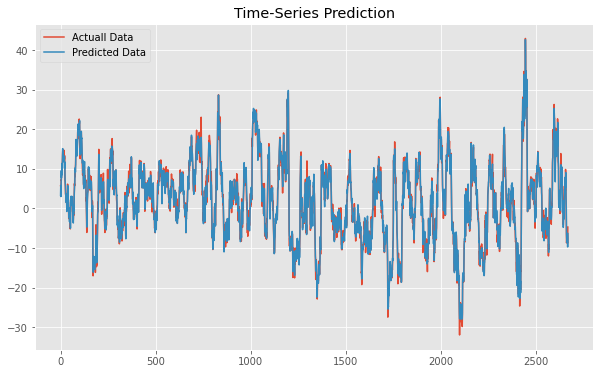

In [27]:
# On complete dataset

train_predict = model_best(X_tensors_final.cuda())#forward pass

data_predict = train_predict.data.cpu()
data_predict = data_predict.numpy() #numpy conversion

dataY_plot = y_tensors.data.cpu()
dataY_plot = dataY_plot.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot.reshape(-1, 1))
plt.figure(figsize=(10,6)) #plotting

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

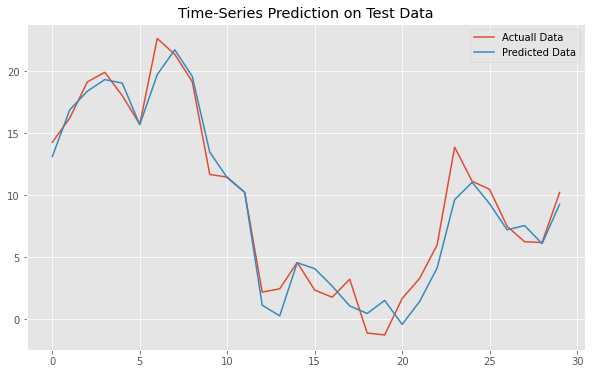

In [28]:
# Only on Test set
# We droped the last 30 values for testing above(during data preprocessing)

X_test= X_train_tensors_final[-30:, :].cuda()
y_test= y_train_tensors[-30:, :].cuda()


test_predict= model_best(X_test) # Forward pass

predicted= test_predict.data.cpu()
predicted= predicted.numpy()

real_test= y_test.data.cpu()
real_test= real_test.numpy()


predicted= mm.inverse_transform(predicted)
real_test= mm.inverse_transform(real_test)

plt.figure(figsize=(10,6)) #plotting
plt.plot(real_test, label='Actuall Data') #actual plot
plt.plot(predicted, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction on Test Data')
plt.legend()
plt.show() 

## R2 score calculation over Test set...

In [29]:
from sklearn.metrics import r2_score
coefficient_of_dermination = r2_score(real_test, predicted)
print(coefficient_of_dermination)

0.9496874998231968


## Saving the model... 

In [33]:
# Saving the LSTM model
import joblib
joblib.dump(model_best, '30DayGrowth%Approch2.pkl')

['30DayGrowth%Approch2.pkl']